In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate


In [2]:
source = pd.read_parquet("source.parquet", columns=["_time", "voltage", "current"]).rename(columns={"_time": "time"}).set_index("time")
source.index = source.index.tz_convert("Europe/Berlin")
source.describe()

,voltage,current
count,2.594773e+06,2.594773e+06
mean,2.239058e+01,3.529806e-01
std,2.721566e+00,3.860165e+01
min,1.500030e+01,-4.842850e+01
25%,2.082450e+01,-4.800310e+01
50%,2.292340e+01,3.270000e-02
75%,2.516700e+01,4.798670e+01
max,2.522070e+01,4.837940e+01


In [3]:
_current = source.loc["2024-10-22 18:35":"2024-10-25 17:30", "current"].resample("100ms").mean().interpolate()

charge_threshold_crossings = (_current > 100e-3).astype(int).diff().fillna(0).astype(int)
discharge_threshold_crossings = (_current < -100e-3).astype(int).diff().fillna(0).astype(int)

charge_start = charge_threshold_crossings.loc[charge_threshold_crossings == 1]
charge_end = charge_threshold_crossings.loc[charge_threshold_crossings == -1]
discharge_start = discharge_threshold_crossings.loc[discharge_threshold_crossings == 1]
discharge_end = discharge_threshold_crossings.loc[discharge_threshold_crossings == -1]

# manually remove some outliers
charge_start.drop("2024-10-23 12:56:00.1", inplace=True)
charge_end.drop("2024-10-23 12:56:00.2", inplace=True)
discharge_start.drop("2024-10-25 17:25:09.7", inplace=True)

cycles = pd.concat(
    [
        discharge_start.reset_index().time.rename("dsg_start"),
        discharge_end.reset_index().time.rename("dsg_end"),
        charge_start.reset_index().time.rename("chg_start"),
        charge_end.reset_index().time.rename("chg_end"),
    ],
    axis=1,
)
cycles.index = pd.RangeIndex(1, len(cycles) + 1, name="cycle")

df = source.resample("100ms").mean().interpolate()
df["power"] = df["voltage"] * df["current"]
df["cycle"] = -1
df["phase"] = ""

for cycle, cs, ce, ds, de in cycles[["chg_start", "chg_end", "dsg_start", "dsg_end"]].itertuples():
    df.loc[cs:ce, "cycle"] = cycle
    df.loc[ds:de, "cycle"] = cycle
    df.loc[cs:ce, "phase"] = "charge"
    df.loc[ds:de, "phase"] = "discharge"

charge_Ah = df.loc[df["cycle"] != -1].groupby(["cycle", "phase"])["current"].aggregate(integrate.trapezoid, dx=0.1).divide(3600).unstack()
energy_Wh = df.loc[df["cycle"] != -1].groupby(["cycle", "phase"])["power"].aggregate(integrate.trapezoid, dx=0.1).divide(3600).unstack()

cycles["dsg_start"] = cycles["dsg_start"].astype("datetime64[s, Europe/Berlin]")
cycles["dsg_end"] = cycles["dsg_end"].astype("datetime64[s, Europe/Berlin]")
cycles["chg_start"] = cycles["chg_start"].astype("datetime64[s, Europe/Berlin]")
cycles["chg_end"] = cycles["chg_end"].astype("datetime64[s, Europe/Berlin]")

cycles["dsg_duration"] = cycles["dsg_end"] - cycles["dsg_start"]
cycles["chg_duration"] = cycles["chg_end"] - cycles["chg_start"]
cycles["dsg_charge_Ah"] = charge_Ah["discharge"]
cycles["chg_charge_Ah"] = charge_Ah["charge"]
cycles["dsg_energy_Wh"] = energy_Wh["discharge"]
cycles["chg_energy_Wh"] = energy_Wh["charge"]
cycles["energy_loss_Wh"] = cycles["chg_energy_Wh"] + cycles["dsg_energy_Wh"]

cycles.to_csv("cycles.csv")


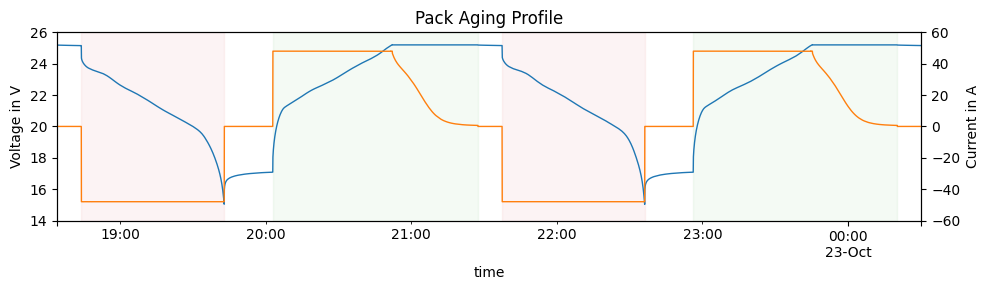

In [4]:
from datetime import timedelta


fig, ax = plt.subplots(1, 1, figsize=(10, 3))

axr = ax.twinx()

start = cycles.loc[1, "dsg_start"] - timedelta(minutes=10)
end = cycles.loc[2, "chg_end"] + timedelta(minutes=10)

source.loc[start:end, "voltage"].resample("1s").mean().plot(ax=ax, lw=1, c="C0", ylim=(14, 26))
source.loc[start:end, "current"].resample("1s").mean().plot(ax=axr, lw=1, c="C1", ylim=(-60, 60))

# Mark discharge and charge phases
for cycle, row in cycles.loc[1:2].iterrows():
    ax.axvspan(row["dsg_start"], row["dsg_end"], alpha=0.05, color="C3")
    ax.axvspan(row["chg_start"], row["chg_end"], alpha=0.05, color="C2")

ax.set_ylabel("Voltage in V")
axr.set_ylabel("Current in A")

ax.set_title("Pack Aging Profile")
fig.tight_layout()
fig.savefig("aging-profile.png")

In [5]:
display(cycles)


,dsg_start,dsg_end,chg_start,chg_end,dsg_duration,chg_duration,dsg_charge_Ah,chg_charge_Ah,dsg_energy_Wh,chg_energy_Wh,energy_loss_Wh
cycle,,,,,,,,,,,
1,2024-10-22 18:44:00+02:00,2024-10-22 19:42:55+02:00,2024-10-22 20:02:55+02:00,2024-10-22 21:27:27+02:00,0 days 00:58:55,0 days 01:24:32,-47.131277,47.819796,-1002.512214,1114.825202,112.312988
2,2024-10-22 21:37:27+02:00,2024-10-22 22:36:14+02:00,2024-10-22 22:56:14+02:00,2024-10-23 00:20:19+02:00,0 days 00:58:47,0 days 01:24:05,-47.026621,47.680482,-1004.570889,1111.685095,107.114206
3,2024-10-23 00:30:19+02:00,2024-10-23 01:28:56+02:00,2024-10-23 01:48:56+02:00,2024-10-23 03:12:42+02:00,0 days 00:58:37,0 days 01:23:46,-46.889785,47.540675,-1002.504069,1108.706611,106.202542
4,2024-10-23 03:22:42+02:00,2024-10-23 04:21:10+02:00,2024-10-23 04:41:10+02:00,2024-10-23 06:04:44+02:00,0 days 00:58:28,0 days 01:23:34,-46.769365,47.416220,-1000.508224,1106.054715,105.546491
5,2024-10-23 06:14:44+02:00,2024-10-23 07:13:04+02:00,2024-10-23 07:33:04+02:00,2024-10-23 08:56:34+02:00,0 days 00:58:20,0 days 01:23:30,-46.656315,47.306552,-998.555826,1103.722992,105.167166
6,2024-10-23 09:06:34+02:00,2024-10-23 10:04:46+02:00,2024-10-23 10:24:46+02:00,2024-10-23 11:47:55+02:00,0 days 00:58:12,0 days 01:23:09,-46.550113,47.198356,-996.689663,1101.489330,104.799667
7,2024-10-23 11:57:55+02:00,2024-10-23 12:56:00+02:00,2024-10-23 13:16:00+02:00,2024-10-23 14:39:01+02:00,0 days 00:58:05,0 days 01:23:01,-46.461063,47.102266,-995.145729,1099.364462,104.218733
8,2024-10-23 14:49:01+02:00,2024-10-23 15:46:59+02:00,2024-10-23 16:06:59+02:00,2024-10-23 17:30:04+02:00,0 days 00:57:58,0 days 01:23:05,-46.369345,47.010909,-993.567933,1097.422260,103.854327
9,2024-10-23 17:40:04+02:00,2024-10-23 18:37:55+02:00,2024-10-23 18:57:55+02:00,2024-10-23 20:21:01+02:00,0 days 00:57:51,0 days 01:23:06,-46.275597,46.920443,-991.863686,1095.529857,103.666171


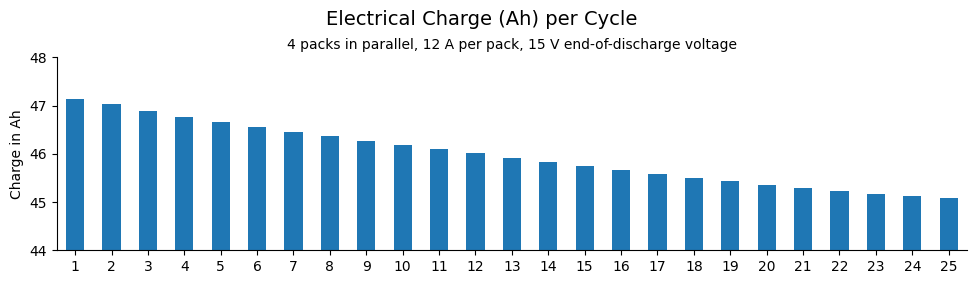

In [6]:
ax = cycles["dsg_charge_Ah"].mul(-1).plot.bar(figsize=(10, 3), ylim=(44, 48), ylabel="Charge in Ah")
plt.suptitle("Electrical Charge (Ah) per Cycle", y=0.93, fontsize=14)
ax.set_title(
    "4 packs in parallel, 12 A per pack, 15 V end-of-discharge voltage",
    fontsize=10,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig("charge-cycles.png")

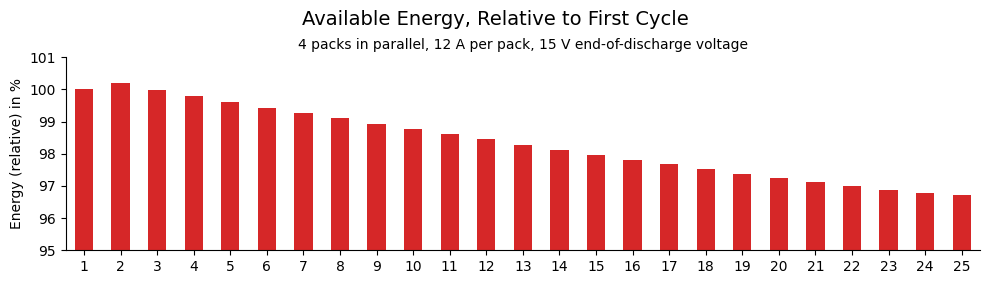

In [7]:
ax = (
    cycles["dsg_energy_Wh"]
    .div(cycles.loc[1, "dsg_energy_Wh"])
    .mul(100)
    .plot.bar(figsize=(10, 3), ylim=(95, 101), ylabel="Energy (relative) in %", color="C3")
)
plt.suptitle("Available Energy, Relative to First Cycle", y=0.93, fontsize=14)
ax.set_title(
    "4 packs in parallel, 12 A per pack, 15 V end-of-discharge voltage",
    fontsize=10,
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel(None)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig("energy-cycles.png")
